<a href="https://colab.research.google.com/github/amutharun/RAG/blob/main/03_Advanced_RAG_MVR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Retrieval-Augmented Generation (RAG): LangChain Implementation
This Notebook implements an advanced RAG system with the following:
* How to retrieve relevant sources using advanced Retriever called  **MultiVectorRetriever**

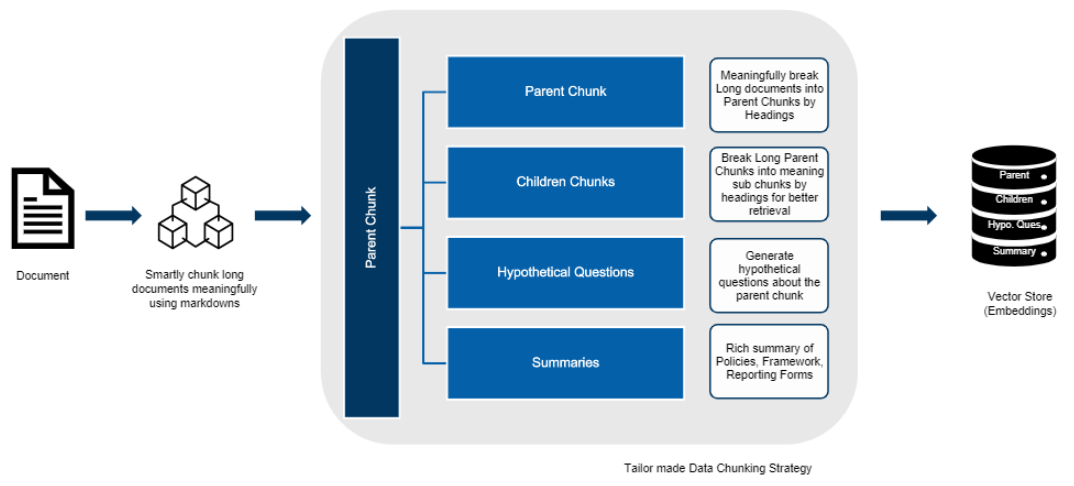

In [2]:
!git clone https://github.com/amutharun/RAG.git

Cloning into 'RAG'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 60 (delta 26), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (60/60), 8.09 MiB | 17.27 MiB/s, done.
Resolving deltas: 100% (26/26), done.


In [ ]:
!pip install -r /content/RAG/rag_requirements.txt

## Imports

In [4]:
import os
import time
import warnings
warnings.filterwarnings("ignore")

from dotenv import load_dotenv
load_dotenv()


True

In [5]:
from langchain.vectorstores import FAISS
from langchain.chat_models import AzureChatOpenAI
from langchain.embeddings.openai import OpenAIEmbeddings
from RAG.utils import pretty_print_result, pretty_print_docs

## Azure - Model & Embeddings Configuration
Define relevant environment variables in a .env file

In [6]:
GPT4_TURBO_DEPLOYMENT_NAME = os.getenv('GPT4_TURBO_DEPLOYMENT_NAME')

API_KEY = os.getenv('API_KEY')
API_BASE = os.getenv('API_BASE')
API_TYPE = os.getenv('API_TYPE')
API_VERSION = os.getenv('API_VERSION')

llm_gpt4_turbo = AzureChatOpenAI(
        openai_api_base=API_BASE,
        openai_api_version=API_VERSION,
        deployment_name=GPT4_TURBO_DEPLOYMENT_NAME,
        openai_api_key=API_KEY,
        openai_api_type=API_TYPE,
        temperature=0
    )

EMBEDDING_API_KEY = os.getenv('API_KEY')
EMBEDDING_API_BASE = os.getenv('API_BASE')
EMBEDDING_DEPLOYMENT_NAME = os.getenv('EMBEDDING_DEPLOYMENT_NAME')

embeddings = OpenAIEmbeddings(deployment=EMBEDDING_DEPLOYMENT_NAME,
                              openai_api_key=EMBEDDING_API_KEY,
                              openai_api_base=EMBEDDING_API_BASE,
                              openai_api_version=API_VERSION,
                              openai_api_type=API_TYPE,
                              chunk_size=1)

## Document Loading
Load two documents - 2022 & 2023 Microsoft Annual Reports

In [7]:
from langchain.document_loaders import PyPDFLoader

loader = PyPDFLoader('/content/RAG/data/misc/Leave-Policy-India.pdf')
documents = loader.load()
print(len(documents))

8


In [8]:
for item in documents:
    item.metadata['source_type'] = 'Parent'

In [9]:
documents

[Document(page_content='  \n  \nLeave Policy - INDIA \n  \n \n                                                                         \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n    \n', metadata={'source': '/content/RAG/data/misc/Leave-Policy-India.pdf', 'page': 0, 'source_type': 'Parent'}),
 Document(page_content='3   \n                                                                                          \n    \n Policy fact sheet  \n \nPolicy owner:  Global Head of Total Rewards  \nPolicy approver:  Global CHRO / ELT  \nVersion: 1.0 \nDate: 1st October 2020  \nScope This policy applies to all fulltime employees 0f UPL & its \nsubsidiaries based in India.  \nConfidential:  No, for internal use only  \n \n \n         \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', metadata={'source': '/content/RAG/data/misc/Leave-Policy-India.pdf', 'page': 1, 'source_type': 'Parent'}),
 Document(page_content='4   \n Contents \n \n \n1. Purpose  4 \n2. Scope 4 \n3. Process Description  4 \

we treat each page as a parent document

## Type6 - MultiVector Retriever
It can often be beneficial to store multiple vectors per document. There are multiple use cases where this is beneficial. LangChain has a base MultiVectorRetriever which makes querying this type of setup easy.

The methods to create multiple vectors per document include:

**Smaller chunks:** split a document into smaller chunks, and embed those (this is ParentDocumentRetriever).

**Summary:** create a summary for each document, embed that along with (or instead of) the document.

**Hypothetical questions:** create hypothetical questions that each document would be appropriate to answer, embed those along with (or instead of) the document.

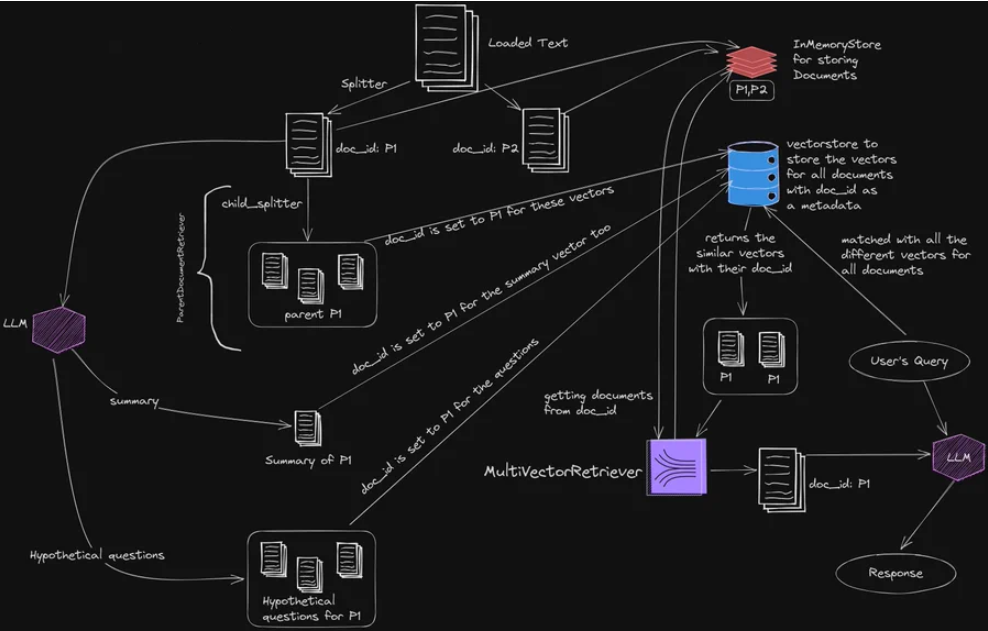

Illustration of how children, summaries and hypothetical questions are made out of a parent

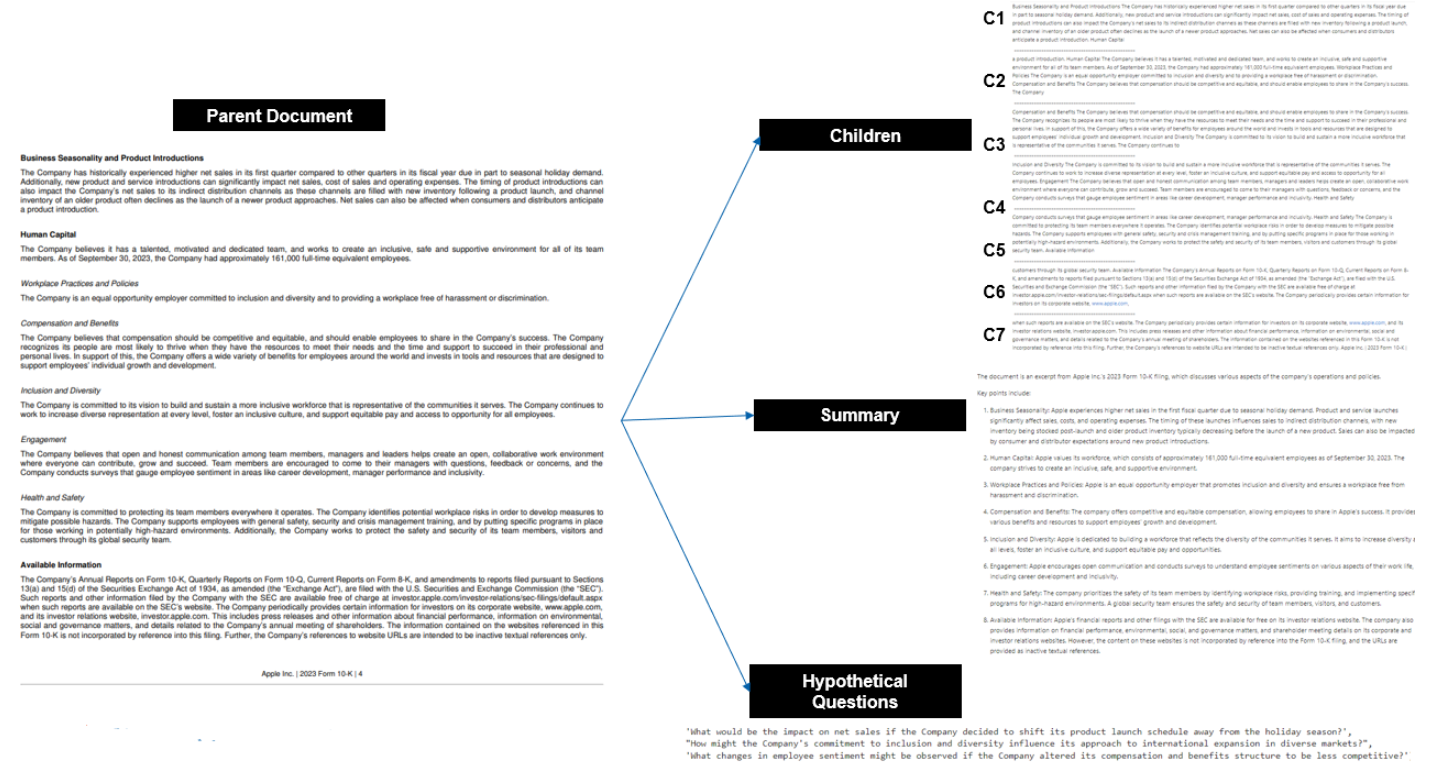

In [10]:
from langchain.retrievers import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain.vectorstores import Chroma
import uuid

#### Smaller chunks
Often times it can be useful to retrieve larger chunks of information, but embed smaller chunks. This allows for embeddings to capture the semantic meaning as closely as possible, but for as much context as possible to be passed downstream.

In [11]:
# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="full_documents", embedding_function=embeddings)

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

doc_ids = [str(uuid.uuid4()) for _ in documents]

In [12]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# The splitter to use to create smaller chunks
child_text_splitter = RecursiveCharacterTextSplitter(chunk_size=600, separators=["\n\n","\n"])

sub_docs = []
for i, doc in enumerate(documents):
    _id = doc_ids[i]
    _sub_docs = child_text_splitter.split_documents([doc])
    for _doc in _sub_docs:
        _doc.metadata[id_key] = _id
    sub_docs.extend(_sub_docs)

for item in sub_docs:
    item.metadata['source_type'] = 'Children'

retriever.vectorstore.add_documents(sub_docs)
retriever.docstore.mset(list(zip(doc_ids, documents)))

In [13]:
# Vectorstore alone retrieves the small chunks
retriever.vectorstore.similarity_search("Maternity leave")[0]

Document(page_content='days of paid leave will be limited to 45 continuous days from the date of such occurrence.  \n\uf0b7 For the purposes of Maternity/miscarriage/medical termination of pregnancy intervening \nweekends/holidays will be calculated as leave days. \n\uf0b7 In case an employee needs to avail Maternity leave / or leave for Medical termination of \npregnancy/ or leave for miscarriage, the request for such leave needs to be forwarded to \nimmediate supervisor along with supporting medical documents. \n\uf0b7 On approval of the leave, the leave details are to be updated along with necessary', metadata={'doc_id': '2e8dc42d-8e74-42bd-8fb2-66fcfa6eea8c', 'page': 6, 'source': '/content/RAG/data/misc/Leave-Policy-India.pdf', 'source_type': 'Children'})

In [14]:
# Retriever returns larger chunks
retriever.get_relevant_documents("Maternity leave")[0]

Document(page_content='  \n employee must apply the sick leave in the prescribed online platform immediately on return to \nwork. \n \nAny misuse of the sick leave provision will attract disciplinary action and may lead to termination \nof an employee. \n \n4.5 Maternity Leave  \n \nEligibility - Total of 26 weeks twice in the service tenure as governed by ‘The Maternity \nBenefit Act” & Maternity Benefit (amendment) Bill 2017.  \nApart from the standard Maternity leaves mentioned above, women will be \nentitled for additional 6 weeks of Maternity leaves. \nAccumulation -   Not applicable. \nGuidelines: \n \n\uf0b7 Existing provisions as per Maternity Benefit Act, 1961 & Maternity Benefit (amendment) \nBill 2017 and ESI Act, 1948 will be continued.  \n\uf0b7 All women employees are eligible for a total of 32 weeks of maternity leave for 2 surviving \nchildren. The woman employee can proceed on maternity leave up to a maximum of 26 \nweeks but not more than 8 weeks before the expected d

In [15]:
len(retriever.get_relevant_documents("Maternity leave")[0].page_content)

2162

#### Summary
Oftentimes a summary may be able to distill more accurately what a chunk is about, leading to better retrieval. Here let's see how to create summaries, and then embed those.

In [16]:
import uuid
from langchain.schema.document import Document
from langchain.schema.output_parser import StrOutputParser
from langchain.prompts import ChatPromptTemplate

In [17]:
chain = (
    {"doc": lambda x: x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following document:\n\n{doc}")
    | llm_gpt4_turbo
    | StrOutputParser()
)

summaries = chain.batch(documents, {"max_concurrency": 5})

In [18]:
# Prepare the summaries created in document format
summary_docs = [
    Document(page_content=s, metadata={"source_type" : "summary",id_key: doc_ids[i]})
    for i, s in enumerate(summaries)
]

# let's check how it looks
summaries

['The document appears to be a Leave Policy specific to India, but the content provided is incomplete. To give a summary, I would need more details about the policy, such as the types of leave covered (e.g., annual leave, sick leave, maternity/paternity leave), the eligibility criteria, the process for applying for leave, and any other rules or guidelines associated with the leave policy. If you can provide the full text or key points from the document, I can offer a more accurate summary.',
 'Document Title: Policy Fact Sheet\n\n- Policy Owner: Global Head of Total Rewards\n- Policy Approver: Global CHRO / Executive Leadership Team (ELT)\n- Version: 1.0\n- Date: 1st October 2020\n- Scope: Applicable to all full-time employees of UPL and its subsidiaries based in India.\n- Confidentiality: Not confidential, intended for internal use only.',
 "The document contains six sections:\n\n1. Purpose: Explains the reason for the document.\n2. Scope: Defines the extent of the document's applicab

In [19]:
# Add the summary documents to the vector store
retriever.vectorstore.add_documents(summary_docs)
retriever.docstore.mset(list(zip(doc_ids, documents)))

In [20]:
vectorstore.similarity_search("Maternity leave")

[Document(page_content='The document outlines the maternity and paternity leave policies, as well as general rules governing leave at a company.\n\n- Employees on maternity leave must not work elsewhere during their leave, or they will lose their maternity leave benefits and face disciplinary action. If an employee resigns during maternity leave without returning to work, benefits will stop on their last day of employment. Maternity leave is considered active employment for performance and variable pay purposes.\n\n- Paternity leave is available for male employees for 7 working days when their spouse gives birth or is in a maternity-related medical emergency, but it cannot be accumulated or encashed and is limited to two children. New employees with two children already are not eligible for paternity leave.\n\n- Employees must get approval for planned leaves in advance through the MYUPL leave management application. Unauthorized leaves will result in loss of pay, and leave entitlements

#### Hypothetical Queries
An LLM can also be used to generate a list of hypothetical questions that could be asked of a particular document. These questions can then be embedded

In [21]:
functions = [
    {
        "name": "hypothetical_questions",
        "description": "Generate hypothetical questions",
        "parameters": {
            "type": "object",
            "properties": {
                "questions": {
                    "type": "array",
                    "items": {"type": "string"},
                },
            },
            "required": ["questions"],
        },
    }
]

In [22]:
from langchain.output_parsers.openai_functions import JsonKeyOutputFunctionsParser

chain = (
    {"doc": lambda x: x.page_content}

    | ChatPromptTemplate.from_template(
        "Generate a list of exactly 3 hypothetical questions that the below document could be used to answer:\n\n{doc}"
    )
    | llm_gpt4_turbo.bind(
        functions=functions, function_call={"name": "hypothetical_questions"}
    )
    | JsonKeyOutputFunctionsParser(key_name="questions")
)

chain.invoke(documents[7])

['What would happen if an employee is discovered to be working elsewhere during their maternity leave?',
 'Can an employee who resigns during maternity leave still receive the full benefits of the leave?',
 'Is paternity leave available to male employees with more than two children at the time of joining the company?']

In [24]:
documents[7]

Document(page_content='  \n \uf0b7 If such an employee who has been granted Maternity leave is found working in any other \nestablishment during ones leave period, she shall forfeit her claim for Maternity leave and \nwarrant disciplinary action. \n\uf0b7 If an employee resigns from employment during Maternity leave without resuming duty, \nthe benefit shall be extended only up to the last day of employment with the Company. \n\uf0b7 Any additional leaves used beyond 225 days & the accumulated PL balance will be treated \nas Loss of pay. \n\uf0b7 During the maternity leave, women employees will be considered as active employees for \nperformance management process and variable pay outs if any. \n \n4.6 Paternity Leave  \n \nEligibility - 7 working days (excluding holidays & intervening weekends). \nAccumulation - Cannot be accumulated or encashed. \nMale employees whose spouse has given birth to a baby or is under medical supervision due to \na maternity related emergency or situation 

In [23]:
hypothetical_questions = chain.batch(documents, {"max_concurrency": 5})

question_docs = []
for i, question_list in enumerate(hypothetical_questions):
    question_docs.extend(
        [Document(page_content=s, metadata={"source_type":"Hypothetical Question", id_key: doc_ids[i]}) for s in question_list] )

retriever.vectorstore.add_documents(question_docs)
retriever.docstore.mset(list(zip(doc_ids, documents)))

In [25]:
question_docs

[Document(page_content='What would be the consequences of not adhering to the leave policy in India?', metadata={'source_type': 'Hypothetical Question', 'doc_id': '02298698-7c7b-452f-9913-b07ff62cfc6b'}),
 Document(page_content='How does the leave policy in India compare to other countries?', metadata={'source_type': 'Hypothetical Question', 'doc_id': '02298698-7c7b-452f-9913-b07ff62cfc6b'}),
 Document(page_content='What are the legal requirements for employee leave in India?', metadata={'source_type': 'Hypothetical Question', 'doc_id': '02298698-7c7b-452f-9913-b07ff62cfc6b'}),
 Document(page_content='What would be the impact on full-time employees if the policy scope were expanded to include part-time workers?', metadata={'source_type': 'Hypothetical Question', 'doc_id': 'cbacdaef-3889-42ae-9edf-0fda9a8ebf99'}),
 Document(page_content='How would the policy change if it were to be made confidential and not just for internal use?', metadata={'source_type': 'Hypothetical Question', 'doc_

In [27]:
vectorstore.similarity_search("A employee is working for another company during maternity leave. What should I do?")

[Document(page_content='What would happen if a woman employee on maternity leave is discovered to be working for another company during her leave period?', metadata={'doc_id': '47c98fb8-4584-4d8d-9533-ef3eec5ba056', 'source_type': 'Hypothetical Question'}),
 Document(page_content='Can an employee combine personal leave with maternity leave in the event of illness arising from pregnancy, and if so, under what conditions?', metadata={'doc_id': '2e8dc42d-8e74-42bd-8fb2-66fcfa6eea8c', 'source_type': 'Hypothetical Question'}),
 Document(page_content='Can a male employee who has two children before joining the company avail paternity leave if his spouse has another child?', metadata={'doc_id': '47c98fb8-4584-4d8d-9533-ef3eec5ba056', 'source_type': 'Hypothetical Question'}),
 Document(page_content='If a woman employee has already taken maternity leave for two surviving children, what is the maximum duration of maternity leave she can take for a third child?', metadata={'doc_id': '2e8dc42d-8e7

In [26]:
query = "A employee is working for another company during maternity leave. What should I do?"
pretty_print_result(query, llm_gpt4_turbo, retriever)

Answer: Report the situation to HR as the employee is in violation of the company's maternity leave policy, which states that working for another establishment during maternity leave can lead to forfeiture of the leave and disciplinary action.
No of documents retrieved2
Document 1:

  
  If such an employee who has been granted Maternity leave is found working in any other 
establishment during ones leave period, she shall forfeit her claim for Maternity leave and 
warrant disciplinary action. 
 If an employee resigns from employment during Maternity leave without resuming duty, 
the benefit shall be extended only up to the last day of employment with the Company. 
 Any additional leaves used beyond 225 days & the accumulated PL balance will be treated 
as Loss of pay. 
 During the maternity leave, women employees will be considered as active employees for 
performance management process and variable pay outs if any. 
 
4.6 Paternity Leave  
 
Eligibility - 7 working days (excludin